In [1]:
import pandas as pd

df_posts = pd.read_csv('./merged_questions.csv')
df_comments = pd.read_csv('./merged_comments.csv')

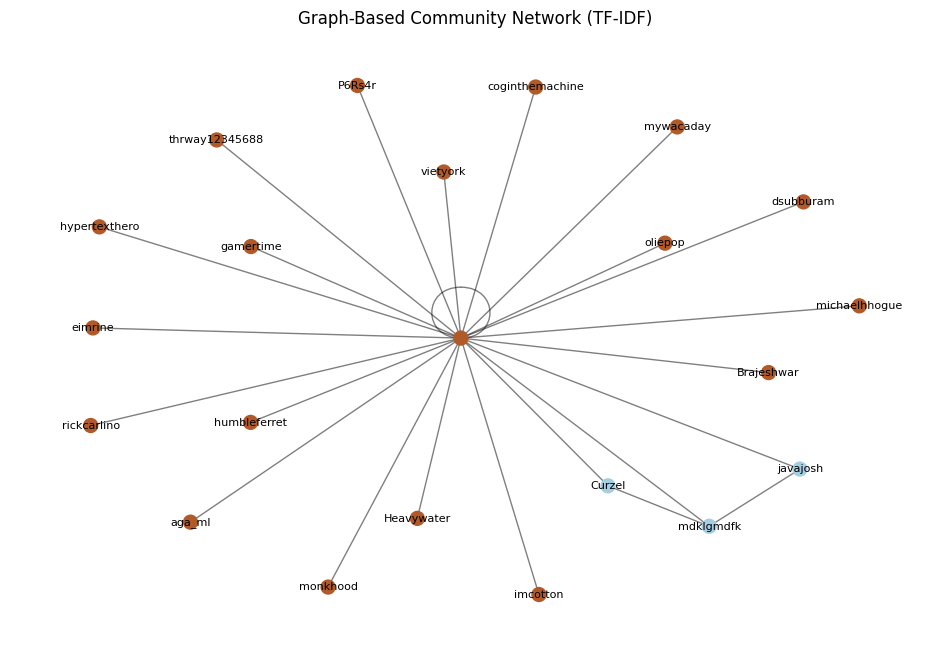

In [2]:
import networkx as nx
import community.community_louvain as louvain
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

posts_info = df_posts.groupby('User')['Question'].apply(' '.join).reset_index(name='PostsText')
comments_info = df_comments.groupby('Author')['Comment'].apply(' '.join).reset_index(name='CommentsText')
user_activity = pd.merge(posts_info, comments_info, left_on='User', right_on='Author', how='outer').fillna('')
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(user_activity['PostsText'] + ' ' + user_activity['CommentsText'])
cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)
G = nx.Graph()
for i in range(len(user_activity)):
    for j in range(i + 1, len(user_activity)):
        similarity = cosine_similarities[i, j]
        if similarity > 0.2:
            G.add_edge(user_activity['User'][i], user_activity['User'][j])

partition = louvain.best_partition(G)
user_activity['Community'] = user_activity['User'].map(partition)
pos = nx.spring_layout(G)
plt.figure(figsize=(12, 8))

# Draw nodes colored by community
colors = [partition[node] for node in G.nodes]
nx.draw_networkx_nodes(G, pos, node_color=colors, cmap=plt.cm.Paired, node_size=100)
nx.draw_networkx_edges(G, pos, alpha=0.5)
labels = {node: user_activity.loc[user_activity['User'] == node, 'User'].values[0] for node in G.nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.title('Graph-Based Community Network (TF-IDF)')
plt.axis('off')
plt.show()

In [3]:
user_activity

,User,PostsText,Author,CommentsText,Community
0,Brajeshwar,"Along with many others, I did the Keybase iden...",Brajeshwar,I had no idea about this one. Thanks.reply,1.0
1,ButterWashed,There's a strong possibility I'll be moving fr...,ButterWashed,I didn't think anyone would have a toaster as ...,NaN
2,Curzel,"I'm looking to sell my side project, a macOS A...",,,0.0
3,DiscoRiver,"I received some advice early in my career, fro...",DiscoRiver,I'm still employed until the 31st of this mont...,NaN
4,Heavywater,I have a task to document whole network setup ...,,,1.0
...,...,...,...,...,...
668,,,zero-sharp,I'm definitely out of the loop in the tech wor...,1.0
669,,,zerr,I first got similar feelings when Bootstrap CS...,1.0
670,,,zipping1549,I'm curious: how come there are no German vers...,1.0
671,,,zulban,"Good luck making a beautiful ""website"" 40 year...",1.0


In [5]:
comments_per_link = df_comments.groupby('Link')['Comment'].count().reset_index()
df_combined = pd.merge(df_posts, comments_per_link, on='Link', how='outer').fillna(0)
df_combined['InfluenceScore'] = df_combined['Score'] + df_combined['Comment']
most_influential_user = df_combined.groupby('User')['InfluenceScore'].sum().idxmax()
print(df_combined.head(2))
print()
print(f"The most influential user is: {most_influential_user}")

                                               Title          User  \
0  Ask HN: Those who've joined a friend's startup...  humbleferret   
1  Ask HN: How to deploy money effectively to sav...        aga_ml   

  Relative time        Date      Time  Score  \
0   6 hours ago  2024-01-28  23:41:15     73   
1   3 hours ago  2024-01-29  02:51:27     16   

                                            Link  \
0  https://news.ycombinator.com/item?id=39171079   
1  https://news.ycombinator.com/item?id=39172196   

                                            Question  Comment  InfluenceScore  
0  While much has been said about co-founding wit...       88             161  
1  Starting a company is a lot of work and requir...        7              23  

The most influential user is: keepamovin


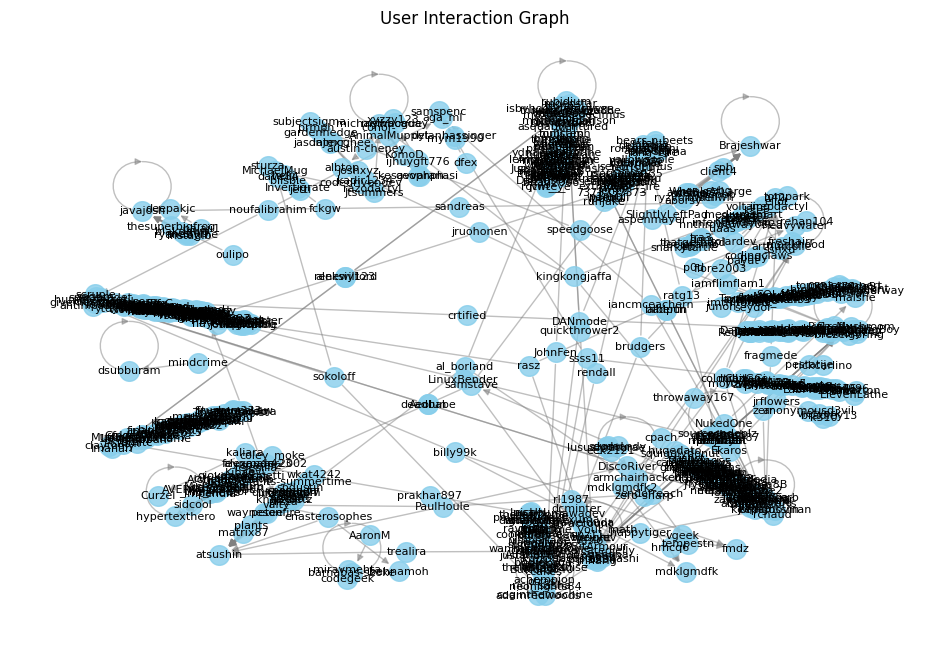

In [6]:
G = nx.DiGraph()

users = set(df_posts['User']).union(set(df_comments['Author']))
G.add_nodes_from(users)

for index, row in df_comments.iterrows():
    G.add_edge(row['Author'], df_posts.loc[df_posts['Link'] == row['Link'], 'User'].values[0])

pos = nx.spring_layout(G)
plt.figure(figsize=(12, 8))

nx.draw_networkx_nodes(G, pos, node_size=200, node_color='skyblue', alpha=0.8)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title('User Interaction Graph')
plt.axis('off')
plt.show()

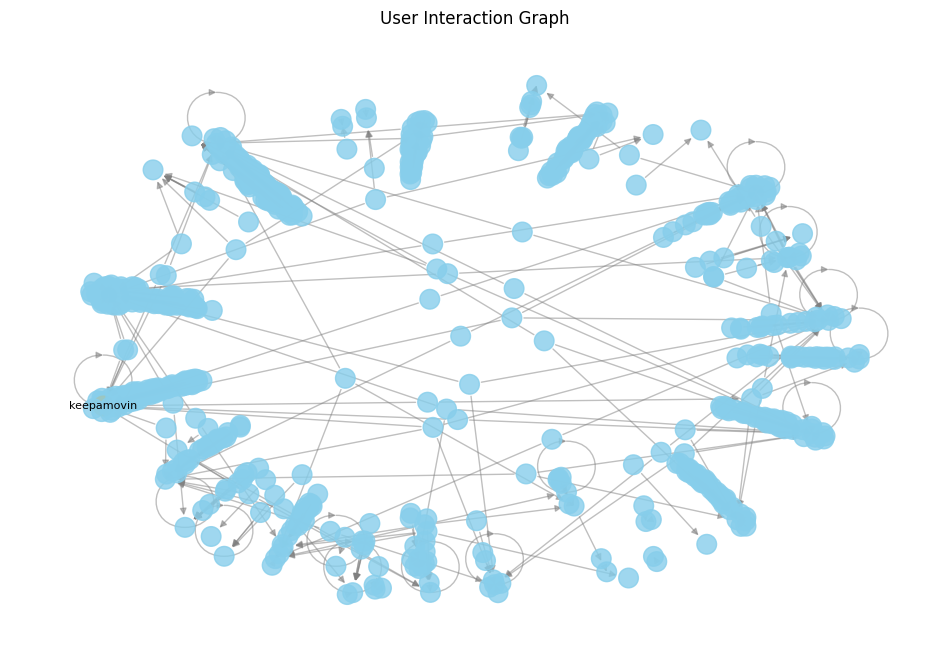

In [8]:
G = nx.DiGraph()

users = set(df_posts['User']).union(set(df_comments['Author']))
G.add_nodes_from(users)

for index, row in df_comments.iterrows():
    G.add_edge(row['Author'], df_posts.loc[df_posts['Link'] == row['Link'], 'User'].values[0])

max_in_degree_node = max(dict(G.in_degree()).items(), key=lambda x: x[1])[0]

pos = nx.spring_layout(G)
plt.figure(figsize=(12, 8))

node_colors = ['orange' if node == max_in_degree_node else 'skyblue' for node in G.nodes]
nx.draw_networkx_nodes(G, pos, node_size=200, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color='gray')

labels = {max_in_degree_node: max_in_degree_node}
nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.title('User Interaction Graph')
plt.axis('off')
plt.show()